In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from itertools import chain

In [9]:
##### global variables ########
LOG = True

MAX_ACC_FRONT = 32768
MAX_GYR = 32768
MAX_ACC_BACK = 8192
MAX_MAG = 8192
MAX_FORCE = 4096

SAMPLE_LENGTH = 64
N_CHANNELS = 13

def log(o):
    if LOG:
        print(o)

In [10]:
with open('../IMWUT_OnHW-chars_dataset_2020-09-22/upper_dep.pkl', 'rb') as read_file:
  data = pickle.load(read_file)

(xtrain, ytrain, xtest, ytest) = data[0]

log(f'training data dimensions: {np.shape(xtrain)}')
log(f'training labels dimensions: {np.shape(ytrain)}')
log(f'test data dimensions: {np.shape(xtest)}')
log(f'test labels dimensions: {np.shape(ytest)}')



training data dimensions: (11737,)
training labels dimensions: (11737,)
test data dimensions: (3913,)
test labels dimensions: (3913,)


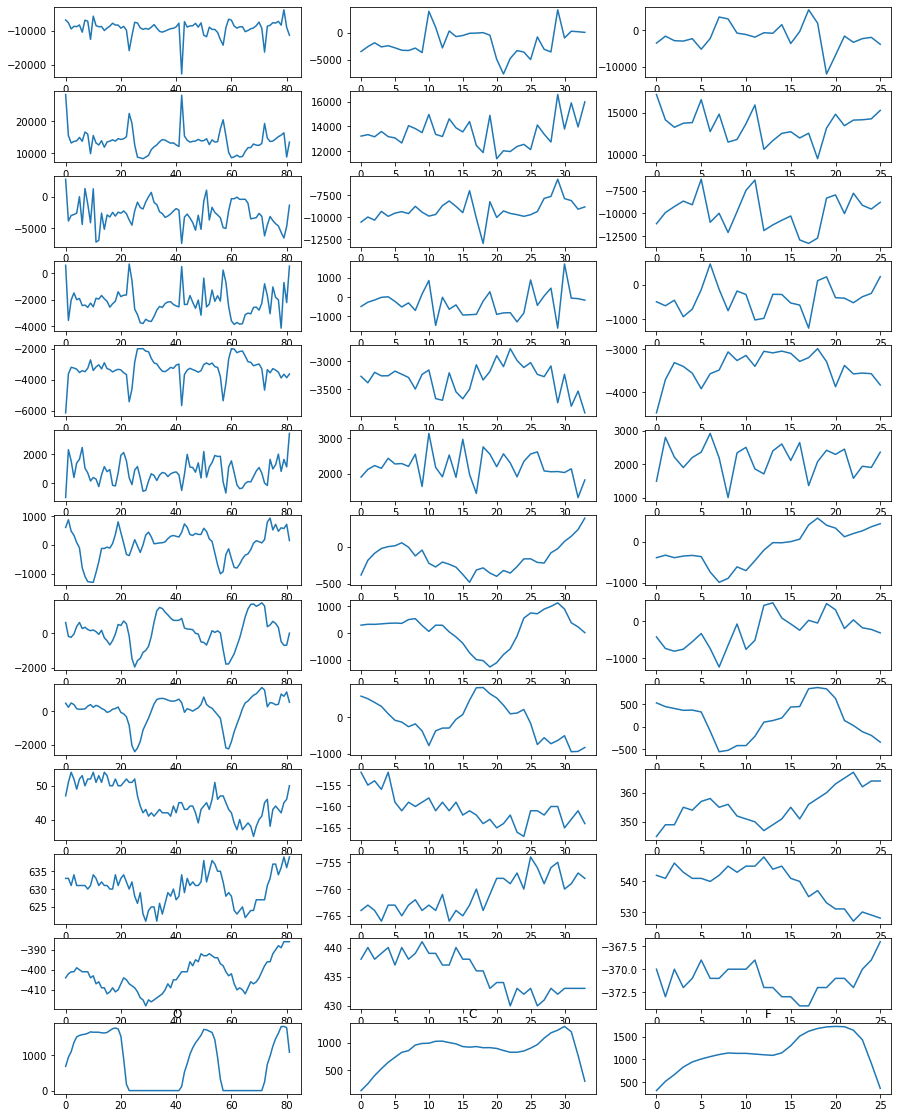

In [11]:
def plot(data, labels, n_ex, n_channels):
    if LOG:
        plt.figure(figsize=(n_ex*5,20*n_channels/13)) # dimensions of the plot in inches
        for i in range(n_ex):
          channels = [] # sensor channels
          for k in range(n_channels):
            channels.append([])
            for j in range(len(data[i])):
              channels[k].append(data[i][j][k])
          for k in range(n_channels):
            plt.subplot(n_channels,n_ex,n_ex*k+i+1)
            # plt.xticks([])
            # plt.yticks([])
            plt.plot(channels[k])
          plt.title(labels[i])
        plt.show()

plot(xtrain, ytrain, 3, 13)


In [12]:
def bounds(xs):
    maxs = []
    mins = []
    for k in range(13):
        maxs.append(0)
        mins.append(0)
    for i in range(len(xs)):
        # per item
        for j in range(len(xs[i])):
            # per timestamp
            for k in range(13):
                x = xs[i][j][k]
                if x > maxs[k]:
                    maxs[k] = x
                if x < mins[k]:
                    mins[k] = x
    return mins, maxs

def log_bounds(min, max):
    log(f'min and max per channel: {list(zip(min, max))}')

log_bounds(*bounds(xtrain))


min and max per channel: [(-32764.0, 32764.0), (-27641.0, 32760.0), (-32758.0, 32764.0), (-8192.0, 8191.0), (-8192.0, 7131.0), (-8192.0, 8191.0), (-10345.0, 8781.0), (-20909.0, 30727.0), (-14387.0, 8605.0), (-1561.0, 2414.0), (-3295.0, 1254.0), (-1914.0, 2984.0), (0, 4095.0)]


In [13]:
def reshape(xs):
  new_xs = []
  for i in range(len(xs)):
    channels = []
    for k in range(len(xs[i][0])):
      channels.append([])
    for j in range(len(xs[i])):
      for k in range(len(xs[i][j])):
        channels[k].append(xs[i][j][k])
    new_xs.append([])
    new_xs[i] = channels
  return new_xs

def unreshape(xs):
  old_xs = []
  for i in range(len(xs)):
    sensors = []
    for j in range(len(xs[i][0])):
      sensors.append([])
    for k in range(len(xs[i])):
      for j in range(len(xs[i][k])):
        sensors[j].append(xs[i][k][j])
    old_xs.append(sensors)
  return old_xs

def resample(xs, desired_length):
  printed = False
  xs = xs.copy()
  for i in range(len(xs)):
    old = xs[i].copy()
    x = np.arange(0, len(xs[i][0]), len(xs[i][0])/desired_length)[:desired_length]
    for k in range(len(xs[i])):
      xp = np.arange(0, len(xs[i][k]))
      xs[i][k] = np.interp(x, xp, xs[i][k])
      if len(xs[i][k]) != desired_length and not printed:
          log(old)
          log(xs[i][k])
          printed = True
  return xs

def convert2numpy(arr):
    arr = np.array(arr.copy())
    for i in range(len(arr)):
        arr[i] = np.array(arr[i])
    return arr

reshaping training and test data before resampling
resampling training and test data such that all sequences are of length 64
reshaping training and test data into original shape
resulting shape of training data: (11737, 64, 13)


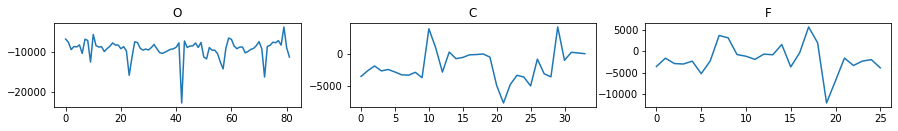

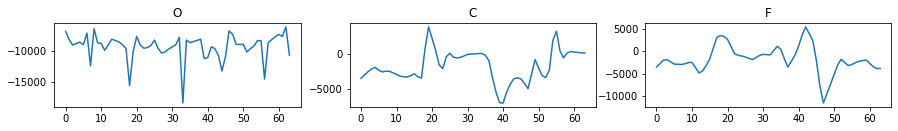

In [14]:
log('reshaping training and test data before resampling')
new_xtrain = reshape(xtrain)
new_xtest = reshape(xtest)

# total_samples = int(np.average(list(map(lambda x: len(x[0]), new_xtrain))))
# log(f'average sequence length: {total_samples}')
# note: this is the average of the training sequence lengths,
#  which might not reflect the average length of the test sequence lengths.

log(f'resampling training and test data such that all sequences are of length {SAMPLE_LENGTH}')
new_xtrain = resample(new_xtrain, SAMPLE_LENGTH)
new_xtest = resample(new_xtest, SAMPLE_LENGTH)

log('reshaping training and test data into original shape')
new_xtrain = unreshape(new_xtrain)
new_xtest = unreshape(new_xtest)

plot(xtrain, ytrain, 3, 1)
plot(new_xtrain, ytrain, 3, 1)

xtrain = new_xtrain
xtest = new_xtest

log(f'resulting shape of training data: {np.shape(xtrain)}')

In [15]:
xtrain = convert2numpy(xtrain)
xtest = convert2numpy(xtest)

In [16]:
# normalization of data
def normalize(xs):
    xs = xs.copy()
    for i in range(len(xs)):
        # per item
        for j in range(len(xs[i])):
            # per timestamp
            x = xs[i][j]
            x /= [MAX_ACC_FRONT,
                  MAX_ACC_FRONT,
                  MAX_ACC_FRONT,
                  MAX_ACC_BACK,
                  MAX_ACC_BACK,
                  MAX_ACC_BACK,
                  MAX_GYR,
                  MAX_GYR,
                  MAX_GYR,
                  MAX_MAG,
                  MAX_MAG,
                  MAX_MAG,
                  MAX_FORCE/2]
            x[12] -= 1 # since force measurements are only positive.
            # now, all sensor measurements for this timestamp have been normalized
            #  to fit within [-1, 1]
    return xs

xtrain = normalize(xtrain)
xtest = normalize(xtest)
log_bounds(*bounds(xtrain))
log_bounds(*bounds(xtest))


min and max per channel: [(-0.9998779296875, 0.962432861328125), (-0.7547454833984375, 0.99969482421875), (-0.99969482421875, 0.8466057777404785), (-0.9524269104003906, 0.9998779296875), (-1.0, 0.8704833984375), (-1.0, 0.9998779296875), (-0.173004150390625, 0.26280975341796875), (-0.5568938255310059, 0.4810791015625), (-0.385284423828125, 0.2598075866699219), (-0.19049835205078125, 0.2945442199707031), (-0.4021568298339844, 0.1529541015625), (-0.2332763671875, 0.36425018310546875), (-0.99951171875, 0.99951171875)]
min and max per channel: [(-0.9998779296875, 0.99969482421875), (-0.9998779296875, 0.99969482421875), (-0.99969482421875, 0.9998779296875), (-0.9769783020019531, 0.943939208984375), (-1.0, 0.9998779296875), (-1.0, 0.98974609375), (-0.30843162536621094, 0.2713947296142578), (-0.3343639373779297, 0.48175811767578125), (-0.28560733795166016, 0.18334007263183594), (-0.15374755859375, 0.2649993896484375), (-0.4032783508300781, 0.2619972229003906), (-0.4386138916015625, 0.363513946

In [17]:
vocab = sorted(set(ytrain))
log(f'vocab: {vocab}')

vocab: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [18]:
ids_from_chars = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None, num_oov_indices=0)
log(ids_from_chars.get_vocabulary())
log(ids_from_chars(ids_from_chars.get_vocabulary()))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25], shape=(26,), dtype=int64)


In [19]:
chars_train = ytrain.copy()
chars_test = ytest.copy()
ids_train = ids_from_chars(chars_train)
ids_test = ids_from_chars(chars_test)

labels_train = np.array(ids_train).reshape((-1,1))
labels_test = np.array(ids_test).reshape((-1,1))

In [20]:
log(f'set of training label ids: {set(np.array(ids_train))}')
log(f'shape of training labels: {np.shape(labels_train)}')
log(f'set of test label ids: {set(np.array(ids_test))}')
log(f'shape of test labels: {np.shape(labels_test)}')


set of training label ids: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
shape of training labels: (11737, 1)
set of test label ids: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
shape of test labels: (3913, 1)


In [21]:
model = models.Sequential()
model.add(layers.Conv1D(64,4,activation='relu', input_shape=(SAMPLE_LENGTH, N_CHANNELS)))
model.add(layers.Dropout(0.4))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64,4,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 61, 64)            3392      
_________________________________________________________________
dropout (Dropout)            (None, 61, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0

In [23]:
N_TRAIN = 10000
N_TEST = 1000
lr = 0.001
epochs = 20
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              )
history = model.fit(xtrain, labels_train, epochs=epochs, validation_data=(xtest, labels_test))

Epoch 1/20
367/367 [==============================] - 3s 4ms/step - loss: 2.9336 - accuracy: 0.1354 - val_loss: 2.8064 - val_accuracy: 0.21
Epoch 2/20
367/367 [==============================] - 1s 4ms/step - loss: 2.5225 - accuracy: 0.2621 - val_loss: 2.5243 - val_accuracy: 0.31
Epoch 3/20
367/367 [==============================] - 1s 4ms/step - loss: 2.2289 - accuracy: 0.3490 - val_loss: 2.2883 - val_accuracy: 0.38
Epoch 4/20
367/367 [==============================] - 1s 3ms/step - loss: 2.0153 - accuracy: 0.3937 - val_loss: 2.1610 - val_accuracy: 0.40
Epoch 5/20
367/367 [==============================] - 1s 3ms/step - loss: 1.8537 - accuracy: 0.4241 - val_loss: 2.0459 - val_accuracy: 0.41
Epoch 6/20
367/367 [==============================] - 1s 3ms/step - loss: 1.7426 - accuracy: 0.4545 - val_loss: 1.9188 - val_accuracy: 0.45
Epoch 7/20
367/367 [==============================] - 1s 3ms/step - loss: 1.6298 - accuracy: 0.4759 - val_loss: 1.8377 - val_accuracy: 0.46
Epoch 8/20
367/367 [

{'learning rate': 0.001, 'epochs': 20, 'Max acc': 0.6839056015014648, 'Max val_acc': 0.5788397789001465}


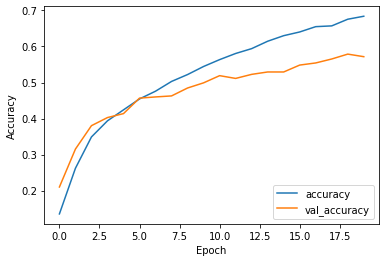

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
print({'learning rate': lr,
       'epochs': epochs,
       'Max acc': max(history.history['accuracy']),
       'Max val_acc': max(history.history['val_accuracy'])})
